Since our data is time series, we must:
    1. Perform 31-day sliding window min-max scaling
    2. Create a 0-1 binary predictor variables on whether the coin was pumped
For __OHLCV__ Data

In [1]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mticker
import pickle
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
print(os.getcwd())

/Users/hn/Documents/USC Others/ISI Research/PumpCoin/CrytoCompare/All_Pump_Analysis/Final_Analysis


# PART 1: SLIDING WINDOW NORMALIZATION

### GENERAL PROCEDURE FOR WINDOW NORMALIZATION
1. Iterate through row
2. For each of the group of variables (x_d0 to x_d31), apply the function
3. This returns an aray, keep appending them until we have the entire array
4. Append the un-scaled features, and now have a complete row
5. Keep stackign them to a blank array

## MIN-MAX NORMALIZATION

In [4]:
def minmaxOHLCV(x,varlist):
    '''
    Perform minmax scaling for the dataframe. 
    FOr OHCLV data, we want to scale the high_0 using 
    statistics from the previous value. 
    @param x: dataframe
    @param varlist: the list variable names used as scaling data
    '''
    x_var = np.array([])
    y_var = np.array([])
    for var in varlist:
        if '_h0' in var:
            y_var = np.append(y_var,var)
        else:
            x_var = np.append(x_var,var)
#     print("y_var:",y_var)
#     print("x_var",x_var)
    assert len(y_var) == 1 
    x_t = x.T
    scaler = MinMaxScaler()
    scaler.fit(x[x_var].T)#Use statistics excluding h_0 data
    x_scaled = scaler.transform(x_t)
    #If the variable y is not empty, then transform y using statisitics of x's
    scaled_data = pd.DataFrame(x_scaled.T, columns=varlist)
    return scaled_data, scaler.data_min_, scaler.data_max_ 

In [5]:
#create a list of features
ohlcv_feat = pd.read_pickle("ohlcv_features_h.pkl")
len(ohlcv_feat)

301

## Import data

In [6]:
d = pd.read_pickle('ohlcv_data_training_h.pkl').reset_index(drop=True)

In [7]:
d.head(3)
print("Data shape", d.shape)

Data shape (59286, 301)


In [8]:
col_dict = pd.read_pickle("ohlcv_dict_h.pkl")
print(col_dict.keys())

dict_keys(['open', 'high', 'low', 'close', 'volumefrom', 'volumeto', 'core'])


## Convert to Satoshi

In [9]:
sat_list = sum([ v for k,v  in col_dict.items() if k not in 'core'],[])

In [10]:
for var in sat_list:
    d[var] = d[var].apply(lambda x: x*1e8 if x >= 1e-10 else x*1e8 + 1)

In [11]:
#Save satoshi version
d.to_pickle("ohlcv_satoshi_data_h.pkl")

## Normalization

In [12]:
orig_cols = list(d.columns)
d_scaled = d[col_dict['core']]
d_temp = np.zeros(shape=(1,d.shape[1]))
print("d_temp", d_temp.shape)

for k,v in col_dict.items():
    if k != 'core':
#         print(k,v)
        var = col_dict[k]
        d_temp, smin, smax  = minmaxOHLCV(d[var], var)
        scale_stats = pd.DataFrame({k+'_min':smin,k+'_max':smax})
#         print(var)
        print(d_temp.shape, type(d_temp))
        d_scaled = pd.concat((d_scaled,d_temp),axis=1)
        d_scaled = pd.concat((d_scaled,scale_stats),axis=1)

d_temp (1, 301)
(59286, 49) <class 'pandas.core.frame.DataFrame'>
(59286, 49) <class 'pandas.core.frame.DataFrame'>
(59286, 49) <class 'pandas.core.frame.DataFrame'>
(59286, 49) <class 'pandas.core.frame.DataFrame'>
(59286, 49) <class 'pandas.core.frame.DataFrame'>
(59286, 49) <class 'pandas.core.frame.DataFrame'>


In [13]:
#Verify that the scaled dataset has the same shape as the original
d_scaled.shape
assert d_scaled.shape[0] == d.shape[0]
assert d_scaled.shape[1] == d.shape[1] + 12 # 2 statistics for 6 varibales

In [14]:
d_scaled['pumped_yn'] = 0
d_scaled.loc[d_scaled.currency == d_scaled.coin_name, 'pumped_yn'] = 1

###  PLOT THE VARIABLE GROUPS TO MAKE SURE THE SCALED ARE THE SAME
Check that the plots are essential the same, just with range normalized between and 0 and 1

48949    RLC
Name: currency, dtype: object


,currency,exchange,pumptime_edited,coin_name,timestamp,event_date,event_time,open_h0,open_h1,open_h2,open_h3,open_h4,open_h5,open_h6,open_h7,open_h8,open_h9,open_h10,open_h11,open_h12,open_h13,open_h14,open_h15,open_h16,open_h17,open_h18,open_h19,open_h20,open_h21,open_h22,open_h23,open_h24,open_h25,open_h26,open_h27,open_h28,open_h29,open_h30,open_h31,open_h32,open_h33,open_h34,open_h35,open_h36,open_h37,open_h38,open_h39,open_h40,open_h41,open_h42,open_h43,open_h44,open_h45,open_h46,open_h47,open_h48,open_min,open_max,high_h0,high_h1,high_h2,high_h3,high_h4,high_h5,high_h6,high_h7,high_h8,high_h9,high_h10,high_h11,high_h12,high_h13,high_h14,high_h15,high_h16,high_h17,high_h18,high_h19,high_h20,high_h21,high_h22,high_h23,high_h24,high_h25,high_h26,high_h27,high_h28,high_h29,high_h30,high_h31,high_h32,high_h33,high_h34,high_h35,high_h36,high_h37,high_h38,high_h39,high_h40,high_h41,...,volumefrom_h3,volumefrom_h4,volumefrom_h5,volumefrom_h6,volumefrom_h7,volumefrom_h8,volumefrom_h9,volumefrom_h10,volumefrom_h11,volumefrom_h12,volumefrom_h13,volumefrom_h14,volumefrom_h15,volumefrom_h16,volumefrom_h17,volumefrom_h18,volumefrom_h19,volumefrom_h20,volumefrom_h21,volumefrom_h22,volumefrom_h23,volumefrom_h24,volumefrom_h25,volumefrom_h26,volumefrom_h27,volumefrom_h28,volumefrom_h29,volumefrom_h30,volumefrom_h31,volumefrom_h32,volumefrom_h33,volumefrom_h34,volumefrom_h35,volumefrom_h36,volumefrom_h37,volumefrom_h38,volumefrom_h39,volumefrom_h40,volumefrom_h41,volumefrom_h42,volumefrom_h43,volumefrom_h44,volumefrom_h45,volumefrom_h46,volumefrom_h47,volumefrom_h48,volumefrom_min,volumefrom_max,volumeto_h0,volumeto_h1,volumeto_h2,volumeto_h3,volumeto_h4,volumeto_h5,volumeto_h6,volumeto_h7,volumeto_h8,volumeto_h9,volumeto_h10,volumeto_h11,volumeto_h12,volumeto_h13,volumeto_h14,volumeto_h15,volumeto_h16,volumeto_h17,volumeto_h18,volumeto_h19,volumeto_h20,volumeto_h21,volumeto_h22,volumeto_h23,volumeto_h24,volumeto_h25,volumeto_h26,volumeto_h27,volumeto_h28,volumeto_h29,volumeto_h30,volumeto_h31,volumeto_h32,volumeto_h33,volumeto_h34,volumeto_h35,volumeto_h36,volumeto_h37,volumeto_h38,volumeto_h39,volumeto_h40,volumeto_h41,volumeto_h42,volumeto_h43,volumeto_h44,volumeto_h45,volumeto_h46,volumeto_h47,volumeto_h48,volumeto_min,volumeto_max,pumped_yn
48949,RLC,Binance,2019-09-02 17:27:01+00:00,RLC,1567445221,2019-09-02,17:27:01,0.352941,0.470588,0.0,0.058824,0.0,0.176471,0.235294,0.352941,0.294118,0.294118,0.176471,0.294118,0.411765,0.352941,0.352941,0.294118,0.411765,0.411765,0.235294,0.588235,0.647059,0.647059,0.588235,0.470588,0.764706,0.882353,0.882353,0.764706,0.705882,0.764706,0.823529,0.764706,0.823529,0.823529,0.823529,0.882353,0.882353,1.0,1.0,0.941176,0.941176,0.941176,1.0,0.823529,0.882353,0.882353,1.0,0.941176,0.882353,1980.0,2150.0,0.222222,0.518519,1.0,0.0,0.0,0.074074,0.111111,0.185185,0.222222,0.185185,0.185185,0.148148,0.222222,0.259259,0.185185,0.185185,0.222222,0.259259,0.222222,0.333333,0.407407,0.37037,0.37037,0.37037,0.444444,0.518519,0.518519,0.518519,0.518519,0.518519,0.518519,0.518519,0.481481,0.518519,0.518519,0.555556,0.518519,0.592593,0.592593,0.592593,0.555556,0.555556,...,0.008675,0.015186,0.089616,0.013224,0.040517,0.014873,0.010055,0.008953,0.002854,0.036055,0.046387,0.000348,0.003232,0.035805,0.010431,0.003012,0.065126,0.000731,0.002628,0.001083,0.005943,0.071692,0.017277,0.013874,0.004491,0.007067,0.028795,0.002086,0.002384,0.003084,0.004958,0.00022,0.000694,0.000446,0.002628,0.0,0.000693,0.001607,0.0,0.002023,0.00227,0.025629,0.016217,0.004387,0.04832,0.01569,1.0,7.192000e+13,0.092393,0.195774,1.0,0.008036,0.01407,0.08316,0.012432,0.038036,0.014187,0.00959,0.008511,0.002683,0.034044,0.044402,0.000329,0.00307,0.033836,0.01,0.002865,0.061996,0.000714,0.002554,0.001058,0.005782,0.068921,0.016964,0.013797,0.004436,0.007009,0.028303,0.002061,0.002367,0.003044,0.004907,0.000219,0.000691,0.000444,0.002626,0.0,0.000694,0.001601,0.0,0.00202,0.002276,0.025475,0.016151,0.00441,0.048472,0.015657,1.0,1.538000e+09,1


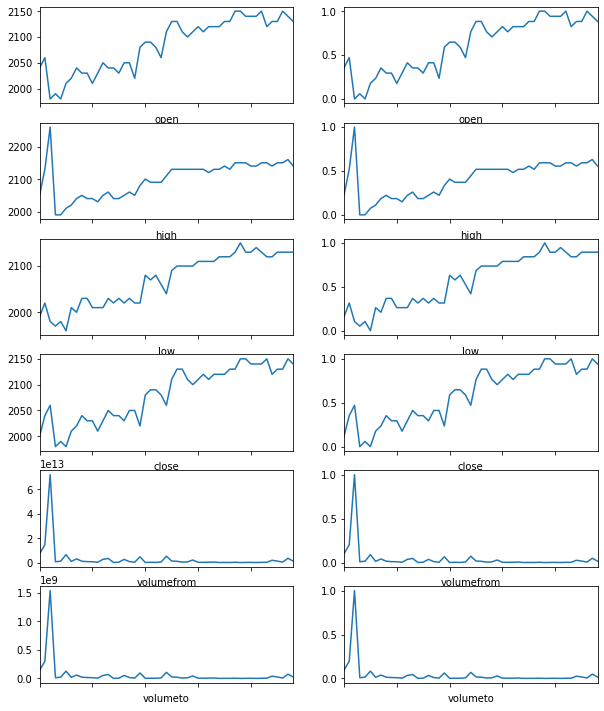

In [15]:
cnt = 0
#Select a random show
r = d_scaled[d_scaled.pumped_yn == 1].sample(1)
# ix = np.random.randint(0,high=5e4,size=1,dtype=int)
# s = d.loc[ix]
# s2 = d_scaled.loc[ix]
s = d.loc[r.index]
s2 = r
fig = plt.figure(figsize=(10,70))
print(r.currency)

for k,v in col_dict.items():
    if k != 'core':
        var = col_dict[k]
        ax1 = fig.add_subplot(33,2,cnt*2+1)
        ax1 = s.iloc[0][var].plot()
        ax1.set_xticklabels([])
        ax1.set_xlabel(k)
        ax2 =fig.add_subplot(33,2,cnt*2+2)
        ax2 = s2.iloc[0][var].plot()
        ax2.set_xticklabels([])
        ax2.set_xlabel(k)
        cnt+=1
r

In [16]:
d_scaled.head()

,currency,exchange,pumptime_edited,coin_name,timestamp,event_date,event_time,open_h0,open_h1,open_h2,open_h3,open_h4,open_h5,open_h6,open_h7,open_h8,open_h9,open_h10,open_h11,open_h12,open_h13,open_h14,open_h15,open_h16,open_h17,open_h18,open_h19,open_h20,open_h21,open_h22,open_h23,open_h24,open_h25,open_h26,open_h27,open_h28,open_h29,open_h30,open_h31,open_h32,open_h33,open_h34,open_h35,open_h36,open_h37,open_h38,open_h39,open_h40,open_h41,open_h42,open_h43,open_h44,open_h45,open_h46,open_h47,open_h48,open_min,open_max,high_h0,high_h1,high_h2,high_h3,high_h4,high_h5,high_h6,high_h7,high_h8,high_h9,high_h10,high_h11,high_h12,high_h13,high_h14,high_h15,high_h16,high_h17,high_h18,high_h19,high_h20,high_h21,high_h22,high_h23,high_h24,high_h25,high_h26,high_h27,high_h28,high_h29,high_h30,high_h31,high_h32,high_h33,high_h34,high_h35,high_h36,high_h37,high_h38,high_h39,high_h40,high_h41,...,volumefrom_h3,volumefrom_h4,volumefrom_h5,volumefrom_h6,volumefrom_h7,volumefrom_h8,volumefrom_h9,volumefrom_h10,volumefrom_h11,volumefrom_h12,volumefrom_h13,volumefrom_h14,volumefrom_h15,volumefrom_h16,volumefrom_h17,volumefrom_h18,volumefrom_h19,volumefrom_h20,volumefrom_h21,volumefrom_h22,volumefrom_h23,volumefrom_h24,volumefrom_h25,volumefrom_h26,volumefrom_h27,volumefrom_h28,volumefrom_h29,volumefrom_h30,volumefrom_h31,volumefrom_h32,volumefrom_h33,volumefrom_h34,volumefrom_h35,volumefrom_h36,volumefrom_h37,volumefrom_h38,volumefrom_h39,volumefrom_h40,volumefrom_h41,volumefrom_h42,volumefrom_h43,volumefrom_h44,volumefrom_h45,volumefrom_h46,volumefrom_h47,volumefrom_h48,volumefrom_min,volumefrom_max,volumeto_h0,volumeto_h1,volumeto_h2,volumeto_h3,volumeto_h4,volumeto_h5,volumeto_h6,volumeto_h7,volumeto_h8,volumeto_h9,volumeto_h10,volumeto_h11,volumeto_h12,volumeto_h13,volumeto_h14,volumeto_h15,volumeto_h16,volumeto_h17,volumeto_h18,volumeto_h19,volumeto_h20,volumeto_h21,volumeto_h22,volumeto_h23,volumeto_h24,volumeto_h25,volumeto_h26,volumeto_h27,volumeto_h28,volumeto_h29,volumeto_h30,volumeto_h31,volumeto_h32,volumeto_h33,volumeto_h34,volumeto_h35,volumeto_h36,volumeto_h37,volumeto_h38,volumeto_h39,volumeto_h40,volumeto_h41,volumeto_h42,volumeto_h43,volumeto_h44,volumeto_h45,volumeto_h46,volumeto_h47,volumeto_h48,volumeto_min,volumeto_max,pumped_yn
0,***,Binance,2018-06-01 12:00:00+00:00,VIB,1527854400,2018-06-01,12:00:00,0.182927,0.317073,0.512195,0.646341,0.573171,0.719512,0.621951,0.634146,0.634146,0.670732,0.878049,0.768293,0.829268,0.780488,0.951220,0.890244,0.707317,0.792683,0.939024,0.902439,0.597561,0.426829,0.317073,0.609756,0.463415,0.597561,0.524390,0.231707,0.500000,0.451220,0.097561,0.121951,0.000000,0.146341,0.158537,0.365854,0.268293,0.170732,0.158537,0.182927,0.146341,0.256098,0.146341,0.280488,0.451220,0.329268,0.719512,0.902439,1.000000,1707.0,1789.0,0.081081,0.405405,0.391892,0.621622,0.648649,0.783784,0.729730,0.608108,0.608108,0.608108,0.729730,0.729730,0.689189,0.675676,0.864865,1.000000,0.878378,0.675676,0.824324,0.878378,0.797297,0.486486,0.324324,0.770270,0.472973,0.472973,0.527027,0.337838,0.324324,0.310811,0.337838,0.135135,0.027027,0.000000,0.000000,0.229730,0.202703,0.189189,0.054054,0.013514,0.067568,0.108108,...,0.067162,0.144037,0.833909,0.359931,0.033570,0.000071,0.000625,0.014750,0.018638,0.010689,0.027105,0.052695,0.025565,0.007081,0.026929,0.720015,0.047536,0.042589,0.047009,0.022412,0.303069,0.013205,0.007649,0.028502,0.451852,1.000000,0.271135,0.183883,0.024365,0.026033,0.040542,0.008489,0.009021,0.003327,0.012698,0.011465,0.010514,0.000000,0.397271,0.395832,0.052648,0.005789,0.069998,0.089530,0.022520,0.019918,2.184300e+12,2.799677e+14,0.053290,0.073389,0.148807,0.068182,0.146891,0.851497,0.366625,0.034191,0.000206,0.000796,0.015175,0.019257,0.011139,0.027984,0.054082,0.026693,0.007506,0.027797,0.741526,0.049187,0.043855,0.047729,0.022569,0.303100,0.013551,0.007858,0.029067,0.452852,1.000000,0.273941,0.184881,0.024319,0.025818,0.040085,0.008404,0.009014,0.003374,0.012663,0.011357,0.010437,0.000000,0.397

In [17]:
d_scaled.head(10)[['pumptime_edited','currency','exchange','coin_name','pumped_yn']]

,pumptime_edited,currency,exchange,coin_name,pumped_yn
0,2018-06-01 12:00:00+00:00,***,Binance,VIB,0
1,2018-06-01 12:00:00+00:00,***,Binance,STEEM,0
2,2018-06-01 12:00:00+00:00,***,Binance,NEBL,0
3,2018-06-01 12:00:00+00:00,***,Binance,WABI,0
4,2018-06-01 12:00:00+00:00,***,Binance,FTM,0
5,2018-06-01 12:00:00+00:00,***,Binance,ONT,0
6,2018-06-01 12:00:00+00:00,***,Binance,FET,0
7,2018-06-01 12:00:00+00:00,***,Binance,XZC,0
8,2018-06-01 12:00:00+00:00,***,Binance,GVT,0
9,2018-06-01 12:00:00+00:00,***,Binance,SYS,0


In [18]:
d_scaled.sort_values(['exchange','coin_name','timestamp']).head(10)

,currency,exchange,pumptime_edited,coin_name,timestamp,event_date,event_time,open_h0,open_h1,open_h2,open_h3,open_h4,open_h5,open_h6,open_h7,open_h8,open_h9,open_h10,open_h11,open_h12,open_h13,open_h14,open_h15,open_h16,open_h17,open_h18,open_h19,open_h20,open_h21,open_h22,open_h23,open_h24,open_h25,open_h26,open_h27,open_h28,open_h29,open_h30,open_h31,open_h32,open_h33,open_h34,open_h35,open_h36,open_h37,open_h38,open_h39,open_h40,open_h41,open_h42,open_h43,open_h44,open_h45,open_h46,open_h47,open_h48,open_min,open_max,high_h0,high_h1,high_h2,high_h3,high_h4,high_h5,high_h6,high_h7,high_h8,high_h9,high_h10,high_h11,high_h12,high_h13,high_h14,high_h15,high_h16,high_h17,high_h18,high_h19,high_h20,high_h21,high_h22,high_h23,high_h24,high_h25,high_h26,high_h27,high_h28,high_h29,high_h30,high_h31,high_h32,high_h33,high_h34,high_h35,high_h36,high_h37,high_h38,high_h39,high_h40,high_h41,...,volumefrom_h3,volumefrom_h4,volumefrom_h5,volumefrom_h6,volumefrom_h7,volumefrom_h8,volumefrom_h9,volumefrom_h10,volumefrom_h11,volumefrom_h12,volumefrom_h13,volumefrom_h14,volumefrom_h15,volumefrom_h16,volumefrom_h17,volumefrom_h18,volumefrom_h19,volumefrom_h20,volumefrom_h21,volumefrom_h22,volumefrom_h23,volumefrom_h24,volumefrom_h25,volumefrom_h26,volumefrom_h27,volumefrom_h28,volumefrom_h29,volumefrom_h30,volumefrom_h31,volumefrom_h32,volumefrom_h33,volumefrom_h34,volumefrom_h35,volumefrom_h36,volumefrom_h37,volumefrom_h38,volumefrom_h39,volumefrom_h40,volumefrom_h41,volumefrom_h42,volumefrom_h43,volumefrom_h44,volumefrom_h45,volumefrom_h46,volumefrom_h47,volumefrom_h48,volumefrom_min,volumefrom_max,volumeto_h0,volumeto_h1,volumeto_h2,volumeto_h3,volumeto_h4,volumeto_h5,volumeto_h6,volumeto_h7,volumeto_h8,volumeto_h9,volumeto_h10,volumeto_h11,volumeto_h12,volumeto_h13,volumeto_h14,volumeto_h15,volumeto_h16,volumeto_h17,volumeto_h18,volumeto_h19,volumeto_h20,volumeto_h21,volumeto_h22,volumeto_h23,volumeto_h24,volumeto_h25,volumeto_h26,volumeto_h27,volumeto_h28,volumeto_h29,volumeto_h30,volumeto_h31,volumeto_h32,volumeto_h33,volumeto_h34,volumeto_h35,volumeto_h36,volumeto_h37,volumeto_h38,volumeto_h39,volumeto_h40,volumeto_h41,volumeto_h42,volumeto_h43,volumeto_h44,volumeto_h45,volumeto_h46,volumeto_h47,volumeto_h48,volumeto_min,volumeto_max,pumped_yn
99,***,Binance,2018-06-01 12:00:00+00:00,ADX,1527854400,2018-06-01,12:00:00,0.603175,0.917989,0.928571,0.859788,0.907407,0.851852,0.820106,0.796296,0.690476,0.698413,0.661376,0.748677,0.873016,0.730159,0.904762,1.000000,0.846561,0.751323,0.695767,0.640212,0.664021,0.526455,0.410053,0.574074,0.428571,0.473545,0.510582,0.523810,0.576720,0.531746,0.362434,0.600529,0.505291,0.544974,0.460317,0.558201,0.441799,0.349206,0.296296,0.150794,0.256614,0.338624,0.203704,0.000000,0.158730,0.161376,0.343915,0.526455,0.568783,7970.0,8348.0,0.663366,0.891089,0.904290,0.947195,0.877888,0.917492,0.848185,0.831683,0.742574,0.755776,0.630363,0.742574,0.834983,0.834983,0.874587,0.996700,1.000000,0.834983,0.768977,0.613861,0.584158,0.633663,0.471947,0.478548,0.462046,0.412541,0.468647,0.465347,0.504950,0.475248,0.475248,0.669967,0.607261,0.574257,0.481848,0.607261,0.603960,0.432343,0.227723,0.584158,0.181518,0.168317,...,0.109426,0.143124,0.045862,0.124802,0.067842,0.476020,0.563993,0.037543,0.140717,0.191136,0.000000,0.255660,0.150472,0.308312,0.357305,0.241927,0.334560,0.315990,0.157178,0.128068,0.124492,0.155856,0.138133,0.087115,0.092654,0.118085,0.067935,0.286486,0.608408,0.250793,0.075799,0.081689,0.104207,0.926133,0.184481,0.064173,0.227707,0.052403,0.037553,0.135384,0.108123,0.321973,0.375523,1.000000,0.306927,0.108330,2.656000e+11,9.942500e+12,0.216922,0.341969,0.070223,0.112760,0.146584,0.047290,0.128262,0.069660,0.486105,0.575021,0.037988,0.143381,0.196167,0.000000,0.261252,0.155424,0.318266,0.366440,0.247415,0.338894,0.321085,0.159524,0.128903,0.125572,0.157218,0.139024,0.087392,0.093477,0.118909,0.068353,0.288926,0.614483,0.253693,0.076578,0.082087,0.105329,0.935939,0.185789,0.063676,0.227941,0.051748,0.03

In [19]:
# SAVE THE FILE
d_scaled.to_pickle("ohlcv_data_slide_scaled_h.pkl")

In [20]:
# TEST: VEFITY THE KEPT RANGE AND TRANSFORMATION IS CORRECT
prefix = 'high_'
prefix_var = [prefix + 'h' + str(t) for t in range(0,49)]
test_indices = d[col_dict['core'] + prefix_var ].sample(5).index

In [21]:
d.iloc[test_indices][col_dict['core'] + prefix_var ]

,currency,exchange,pumptime_edited,coin_name,timestamp,event_date,event_time,high_h0,high_h1,high_h2,high_h3,high_h4,high_h5,high_h6,high_h7,high_h8,high_h9,high_h10,high_h11,high_h12,high_h13,high_h14,high_h15,high_h16,high_h17,high_h18,high_h19,high_h20,high_h21,high_h22,high_h23,high_h24,high_h25,high_h26,high_h27,high_h28,high_h29,high_h30,high_h31,high_h32,high_h33,high_h34,high_h35,high_h36,high_h37,high_h38,high_h39,high_h40,high_h41,high_h42,high_h43,high_h44,high_h45,high_h46,high_h47,high_h48
29105,BAT,Binance,2019-03-26 08:51:53+00:00,TNB,1553590313,2019-03-26,08:51:53,82.0,83.0,84.0,84.0,83.0,83.0,83.0,83.0,83.0,82.0,83.0,82.0,82.0,83.0,84.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,85.0,84.0,84.0,84.0,84.0,84.0,83.0,83.0,83.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,83.0,83.0
18396,FUEL,Binance,2018-12-14 14:59:58+00:00,ARK,1544799598,2018-12-14,14:59:58,9340.0,9310.0,9340.0,9390.0,9350.0,9340.0,9280.0,9400.0,9760.0,9350.0,9310.0,9240.0,9300.0,9310.0,9340.0,9310.0,9340.0,9340.0,9340.0,9470.0,9300.0,9250.0,9240.0,9200.0,9200.0,9170.0,9160.0,9180.0,9220.0,9250.0,9250.0,9250.0,9260.0,9260.0,9250.0,9200.0,9140.0,8970.0,8930.0,8870.0,8870.0,8920.0,8930.0,8880.0,8950.0,8950.0,8880.0,8900.0,8930.0
15786,WINGS,Binance,2018-11-07 17:01:56+00:00,SNM,1541610116,2018-11-07,17:01:56,1058.0,1061.0,1080.0,1057.0,1070.0,1070.0,1025.0,1031.0,1058.0,1028.0,994.0,997.0,997.0,994.0,995.0,991.0,1004.0,1023.0,1008.0,1019.0,1002.0,1010.0,1018.0,1020.0,990.0,944.0,950.0,973.0,982.0,967.0,955.0,942.0,941.0,941.0,960.0,974.0,988.0,993.0,999.0,1001.0,993.0,996.0,996.0,997.0,994.0,990.0,993.0,991.0,998.0
24647,MDA,Binance,2019-03-03 14:10:46+00:00,BRD,1551622246,2019-03-03,14:10:46,5859.0,5800.0,5668.0,5666.0,5666.0,5666.0,5625.0,5632.0,5634.0,5630.0,5622.0,5616.0,5614.0,5607.0,5608.0,5598.0,5652.0,5660.0,5686.0,5712.0,5695.0,5696.0,5708.0,5724.0,5700.0,5714.0,5699.0,5693.0,5681.0,5689.0,5667.0,5710.0,5737.0,5913.0,5808.0,5811.0,5809.0,5795.0,5800.0,5800.0,5782.0,5782.0,5747.0,5745.0,5753.0,5737.0,5805.0,5779.0,5787.0
27498,BLZ,Binance,2019-03-15 15:28:51+00:00,ARK,1552663731,2019-03-15,15:28:51,17100.0,17040.0,16920.0,16780.0,16870.0,16950.0,16960.0,16900.0,16830.0,16900.0,16990.0,17040.0,17030.0,17020.0,17190.0,17400.0,17390.0,17200.0,17150.0,17280.0,17330.0,17470.0,17240.0,16930.0,17040.0,17370.0,17850.0,18420.0,17600.0,17780.0,17100.0,17080.0,17200.0,16860.0,16600.0,16580.0,16590.0,16600.0,16780.0,17590.0,16800.0,16900.0,16770.0,17210.0,17220.0,17060.0,17170.0,17200.0,17000.0


In [22]:
print(np.min(d.iloc[test_indices][prefix_var].values,axis=1))
print(np.max(d.iloc[test_indices][prefix_var].values,axis=1))

[   82.  8870.   941.  5598. 16580.]
[   85.  9760.  1080.  5913. 18420.]


In [23]:
d_scaled[col_dict['core'] + [prefix+'min',prefix+'max'] + prefix_var].iloc[test_indices]

,currency,exchange,pumptime_edited,coin_name,timestamp,event_date,event_time,high_min,high_max,high_h0,high_h1,high_h2,high_h3,high_h4,high_h5,high_h6,high_h7,high_h8,high_h9,high_h10,high_h11,high_h12,high_h13,high_h14,high_h15,high_h16,high_h17,high_h18,high_h19,high_h20,high_h21,high_h22,high_h23,high_h24,high_h25,high_h26,high_h27,high_h28,high_h29,high_h30,high_h31,high_h32,high_h33,high_h34,high_h35,high_h36,high_h37,high_h38,high_h39,high_h40,high_h41,high_h42,high_h43,high_h44,high_h45,high_h46,high_h47,high_h48
29105,BAT,Binance,2019-03-26 08:51:53+00:00,TNB,1553590313,2019-03-26,08:51:53,82.0,85.0,0.000000,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333
18396,FUEL,Binance,2018-12-14 14:59:58+00:00,ARK,1544799598,2018-12-14,14:59:58,8870.0,9760.0,0.528090,0.494382,0.528090,0.584270,0.539326,0.528090,0.460674,0.595506,1.000000,0.539326,0.494382,0.415730,0.483146,0.494382,0.528090,0.494382,0.528090,0.528090,0.528090,0.674157,0.483146,0.426966,0.415730,0.370787,0.370787,0.337079,0.325843,0.348315,0.393258,0.426966,0.426966,0.426966,0.438202,0.438202,0.426966,0.370787,0.303371,0.112360,0.067416,0.000000,0.000000,0.056180,0.067416,0.011236,0.089888,0.089888,0.011236,0.033708,0.067416
15786,WINGS,Binance,2018-11-07 17:01:56+00:00,SNM,1541610116,2018-11-07,17:01:56,941.0,1080.0,0.841727,0.863309,1.000000,0.834532,0.928058,0.928058,0.604317,0.647482,0.841727,0.625899,0.381295,0.402878,0.402878,0.381295,0.388489,0.359712,0.453237,0.589928,0.482014,0.561151,0.438849,0.496403,0.553957,0.568345,0.352518,0.021583,0.064748,0.230216,0.294964,0.187050,0.100719,0.007194,0.000000,0.000000,0.136691,0.237410,0.338129,0.374101,0.417266,0.431655,0.374101,0.395683,0.395683,0.402878,0.381295,0.352518,0.374101,0.359712,0.410072
24647,MDA,Binance,2019-03-03 14:10:46+00:00,BRD,1551622246,2019-03-03,14:10:46,5598.0,5913.0,0.828571,0.641270,0.222222,0.215873,0.215873,0.215873,0.085714,0.107937,0.114286,0.101587,0.076190,0.057143,0.050794,0.028571,0.031746,0.000000,0.171429,0.196825,0.279365,0.361905,0.307937,0.311111,0.349206,0.400000,0.323810,0.368254,0.320635,0.301587,0.263492,0.288889,0.219048,0.355556,0.441270,1.000000,0.666667,0.676190,0.669841,0.625397,0.641270,0.641270,0.584127,0.584127,0.473016,0.466667,0.492063,0.441270,0.657143,0.574603,0.600000
27498,BLZ,Binance,2019-03-15 15:28:51+00:00,ARK,1552663731,2019-03-15,15:28:51,16580.0,18420.0,0.282609,0.250000,0.184783,0.108696,0.157609,0.201087,0.206522,0.173913,0.135870,0.173913,0.222826,0.250000,0.244565,0.239130,0.331522,0.445652,0.440217,0.336957,0.309783,0.380435,0.407609,0.483696,0.358696,0.190217,0.250000,0.429348,0.690217,1.000000,0.554348,0.652174,0.282609,0.271739,0.336957,0.152174,0.010870,0.000000,0.005435,0.010870,0.108696,0.548913,0.119565,0.173913,0.103261,0.342391,0.347826,0.260870,0.320652,0.336957,0.228261
